# Daisyworld Equations

## Original Equations


$$
\frac{dA_w}{dt} = A_w ( \beta_w (1 - A_w - A_b) - \chi)
$$


$$
\frac{dA_b}{dt} = A_b ( \beta_b (1 - A_w - A_b) - \chi)
$$

$$\beta_w = 1.0 - 0.003265(295.5 K - T_w)^2$$
$$\beta_b = 1.0 - 0.003265(295.5 K - T_b)^2$$

$$   T^4_e = L \frac{S_0}{4\sigma}(1-\alpha_p)$$

$$
  T^4_w = R L \frac{S_0}{4\sigma}(\alpha_p-\alpha_w) + T^4_e
$$
$$
  T^4_b = R L \frac{S_0}{4\sigma}(\alpha_p-\alpha_b) + T^4_e
$$

$$
  \alpha_p = A_w\alpha_w + A_b\alpha_b + (1 - A_w - A_b)\alpha_g
$$

# Rabbit Equations

Let $P_r$ denote the nondimensional population concentration of rabbits. Suppose the birth rate of rabbits scale proportionally with food availability (total daisy population), and death rate is a constant fraction of population. Then:

$$
\frac{d P_r}{dt} = (\beta_r (A_w + A_b) - \chi_r) P_r
$$

Where $\chi_r$ is a fixed rabbit death rate. Logically speaking, the death rate of rabbits should also be sensitive to food availability in order to model starvation, but if the birth and death rates are modeled by linear functions, the sum will still be a linear function so there is no effective difference. The important feature is that this linear growth function should cross the x-axis and be negative for some value of $(A_w + A_b)$ to be able to model population growth and decline.

The death rate of daisies now has to be a function of rabbit population. Assuming that the rate at which daisies are eaten by rabbits scales with rabbit population:

$$
\chi = \chi_0 + \epsilon_r P_r
$$

Where $\epsilon_r$ is the rate at which rabbits eat daisies, and $\chi_0$ is the base death rate of daisies. 

## Free Parameters
1. White Daisy Albedo $\alpha_w$
2. Black Daisy Albedo $\alpha_b$
3. Ground Albedo $\alpha_g$
4. Insolation Fraction $L$
5. Atmospheric Conductivity $R$
6. Rabbit Birth Rate $\beta_r$
7. Rabbit Death Rate $\chi_r$
8. Rabbit Eating Rate $\epsilon_r$
9. Base Daisy Death Rate $\chi_0$


## Variables

1. White Daisy Fraction $A_w$
2. Black Daisy Fraction $A_b$
3. Planetary Albedo $\alpha_p$
4. White Daisy Local Temperature $T_w$
5. Black Daisy Local Temperature $T_b$
6. Emission Temperature $T_e$
7. White Daisy Growth Rate $\beta_w$
8. Black Daisy Growth Rate $\beta_b$
9. Rabbit Population Concentration $P_r$
10. Actual Daisy Death Rate $\chi$

## ODE Initial Values
1. White Daisy Fraction $A_w$
2. Black Daisy Fraction $A_b$
3. Rabbit Population Concentration $P_r$

# Rabbit Simulation

In [1]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml

******************************
context imported. Front of path:
C:\Users\65948\Documents\repos\numeric_2024
back of path: C:\Users\65948\miniconda3\envs\numeric_2024\Lib\site-packages\Pythonwin
******************************

through C:\Users\65948\Documents\repos\numeric_2024\notebooks\miniproject 2\context.py


## IntegRabbits Class

In [2]:
class IntegRabbits(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi0 S0 L albedo_black R albedo_ground betarabbit chirabbit epsrabbit'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc])
        self.nvars = len(self.yinit)
        return None

    def set_uservars(self, **kwargs):
        for key, newvalue in kwargs.items():
            self.config['uservars'][key] = newvalue
        self.set_yinit()

    def set_initvars(self, **kwargs):
        for key, newvalue in kwargs.items():
            self.config['initvars'][key] = newvalue
        self.set_yinit()

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [3] with the white [0] and black [1]
                    daisy fraction
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[3]=fraction rabbits
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        chi = user.chi0 + user.epsrabbit * y[2]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - chi)
        f[1] = y[1] * (beta_b * bare - chi)
        f[2] = (user.betarabbit * (y[0] + y[1]) - user.chirabbit) * y[2]
        return f

## Parameter Choice

Typically in an ecosystem we expect the equilibrium population of consumers to be much smaller than that of producers. This can be tuned by adjusting the coupling between rabbit and daisy populations in the form of the eating rate $\epsilon_r$, which controls the level of competition between rabbits for finite food. In general, the higher the eating rate, the smaller the ratio of rabbits to daisy population when in stable equilibrium. However, since the population fractions here are dimenionless normalized quantities, the scaling of the parameters are arbitrary. Thus for the sake of ease of visualization, I tuned the parameters whilst aiming for the steady state populations to be around 1:1, and we can think of the population fractions as being normalized by the relative population scale of producers/consumers (with the normalization factors going into the scalings of the parameters).

Another factor that is important is the relative birth and death rates of rabbits. From the equation:

$$
\frac{d P_r}{dt} = (\beta_r (A_w + A_b) - \chi_r) P_r
$$

For positive growth rates, $(A_w + A_b) > \frac{\chi_r}{\beta_r}$. Since $(A_w + A_b)$ ranges from 0 to 1, $\beta_r$ should be greater than $\chi_r$ for a range of positive population growth rates to exist. $\frac{\chi_r}{\beta_r}$ also thus define the minimum population of daisies needed to support a nonzero rabbit population. By setting $\frac{d P_r}{dt}=0$ we also see that this equation exactly dictates the total equilibrium population of daisies. Here I decided to set the equilibrium population of daisies to be 0.5, thus the $\chi_r = 0.5 \beta_r$. 

The equilibrium population $(A_w + A_b)$ also determines the equilibrium population of rabbits by the following equations:

$$
\frac{dA_w + A_b}{dt} = (A_w \beta_w + A_b \beta_b) (1 - A_w - A_b) - (A_w + A_b)\chi
$$

$$
\chi = \chi_0 + \epsilon_r P_r
$$

Again setting the total daisy population to be constant, we have:

$$
\epsilon_r P_r = \frac{(A_w \beta_w + A_b \beta_b)}{A_w + A_b} (1 - A_w - A_b) - \chi_0
$$

Here we see that the equilibrium rabbit population is inversely proportional to $\epsilon_r$ and increases linearly with decreasing $\chi_0$. The parameter $\chi_0$ can thus be used to 'scale up' the overall equilibrium population of the rabbits and daisies. However, this also has the side effect of changing the relative importance of the environment vs. predation in the death rate of daisies.

The absolute scaling of $\chi_r$ and $\beta_r$ determine the absolute scaling of the rabbit growth rate, which in turn determines how sensitively does the rabbit population react to changes in the population of daisies. However, if the scaling is too small relative to $\epsilon_r$, the population of rabbits becomes insensitive to the population of daisies despite the population of daisies being sensitive to the population of rabbits. This asymmetry means that we can see a situation where the population of rabbits continues to grow quickly even while the population of daisies collapses. In general the guideline I followed is for $\epsilon_r$ and the growth rate to be on the same order of magnitude, which means there is little asymmetry in the coupling between rabbit and daisy populations. 

Another important parameter is $L$, which adjusts the level of solar insolation. Based off the graph in Lab 5, shifting L to a value closer to the middle of the plateau means that there is a larger 'buffer' and thus a larger space of starting population fractions that would lead to a stable equilibrium rather than an unstable feedback leading to extremely hot or extremely cold temperatures.



<img src="temp_bw.png" width="50%">

After some iteration, the following parameters were chosen as a starting point: `L=0.95`, `epsrabbit: 0.7`, `beta_rabbit:1.0`, `chi_rabbit:0.5`, `chi_0:0.1`. This results in a roughly 0.5 equilibrium population fraction for rabbits and total daisies.

## Tests

As mentioned in the previous section, with the current set of parameters, we expect the equilibrium total fraction of daisies to be exactly 0.5.

In [101]:
theSolver = IntegRabbits('rabbit_1.yaml')
initdict = {
    'rabbitconc':0.2
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

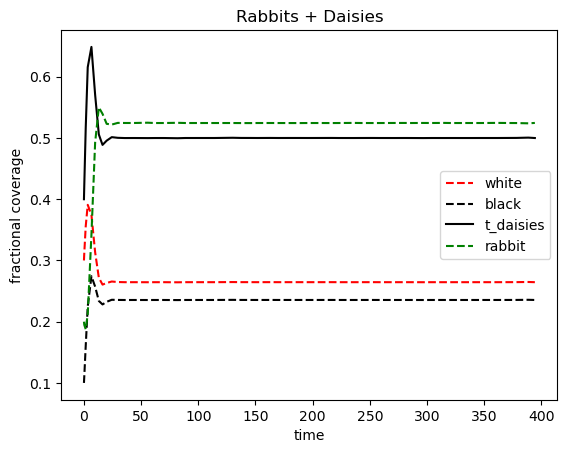

In [102]:
thefig, theAx = plt.subplots(1, 1)

line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line4, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])

line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line4.set(linestyle='-', color='k', label='t_daisies')
line3.set(linestyle='--', color='g', label='rabbit')
theAx.set_title('Rabbits + Daisies')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

As expected, we see that in the plot the equilibrium population of daisies is exactly 0.5.

In [103]:
theSolver = IntegRabbits('rabbit_1.yaml')
initdict = {
    'rabbitconc':0,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

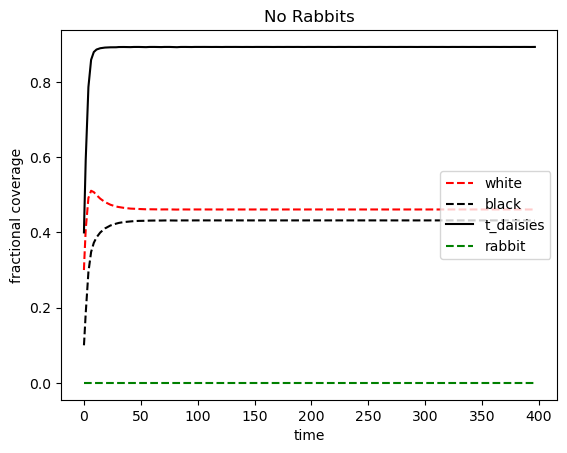

In [104]:
thefig, theAx = plt.subplots(1, 1)

line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line4, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])

line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line4.set(linestyle='-', color='k', label='t_daisies')
line3.set(linestyle='--', color='g', label='rabbit')
theAx.set_title('No Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

When the initial population fo rabbits are set to 0, it remains at 0 as expected since the growth rate of rabbits is proportional to its population. The equilibrium fraction of daisies is also higher without rabbits, as expected.

In [105]:
theSolver = IntegRabbits('rabbit_1.yaml')
initdict = {
    'whiteconc':0,
    'blackconc':0,
    'rabbitconc':1.0,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

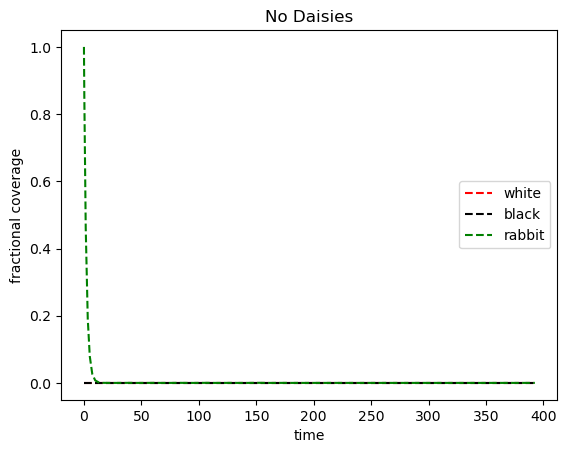

In [106]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
theAx.set_title('No Daisies')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

When there are no daisies, the population of rabbits crash quickly due to starvation.

In [107]:
theSolver = IntegRabbits('rabbit_1.yaml')
initdict = {
    'whiteconc':0.0,
    'blackconc':0.5,
    'rabbitconc':0.5,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits'])

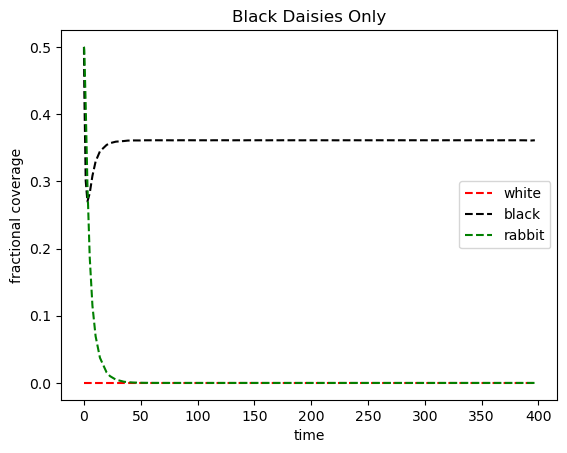

In [108]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
theAx.set_title('Black Daisies Only')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

With only black daisies, the total equilibrium population of daisies falls below 0.5. This is below the minimum threshold needed for rabbits to maintain a positive growth rate, and the population of rabbits collapses.

# Fox Equations

Let $P_f$ denote the nondimensional population concentration of foxes. We can make similar assumptions as in the case of rabbits, where the growth rate scales linearly with the population of rabbits but can be negative below a threshold rabbit population. Then:

$$
\frac{d P_f}{dt} = (\beta_f P_r - \chi_f) P_f
$$

$$
\chi_r = \chi_{r0} + \epsilon_f P_f
$$

Where $\chi_f$ is a fixed fox death rate, $\epsilon_f$ is the rate at which foxes eat rabbits, and $\chi_r0$ is the base death rate of rabbits. The death rate of rabbits is now no longer a fixed parameter, but is linearly dependent on the fox population.

We can apply the same analysis for equilibrium populations. Setting $\frac{d P_f}{dt} = 0$, we find that the equilibrium population of rabbits is fixed at $P_r = \frac{\chi_f}{\beta_f}$. However, the equilibrium population of rabbits is coupled to the equilibrium population of daisies:
$$
\epsilon_r P_r = \frac{(A_w \beta_w + A_b \beta_b)}{A_w + A_b} (1 - A_w - A_b) - \chi_0
$$

Looking at the equation for rabbits:

$$
\frac{d P_r}{dt} = (\beta_r (A_w + A_b) - \chi_{r0} - \epsilon_f P_f) P_r
$$

By imposing the equilibrium condition $\frac{d P_r}{dt} = 0$ we have the relation:
$$P_f = \frac{\chi_{r0} + \beta_r (A_w + A_b)}{\epsilon_f}$$
Thus we see that the exact position of the equilibrium depends on interactions between the fox, rabbit and daisy components of the system.



## Free Parameters
1. White Daisy Albedo $\alpha_w$
2. Black Daisy Albedo $\alpha_b$
3. Ground Albedo $\alpha_g$
4. Insolation Fraction $L$
5. Atmospheric Conductivity $R$
6. Rabbit Birth Rate $\beta_r$
7. Base Rabbit Death Rate $\chi_r0$
8. Rabbit Eating Rate $\epsilon_r$
9. Base Daisy Death Rate $\chi_0$
10. Fox Birth Rate $\beta_f$
11. Fox Death Rate $\chi_f$
12. Fox Eating Rate $\epsilon_f$

## Variables

1. White Daisy Fraction $A_w$
2. Black Daisy Fraction $A_b$
3. Planetary Albedo $\alpha_p$
4. White Daisy Local Temperature $T_w$
5. Black Daisy Local Temperature $T_b$
6. Emission Temperature $T_e$
7. White Daisy Growth Rate $\beta_w$
8. Black Daisy Growth Rate $\beta_b$
9. Rabbit Population Concentration $P_r$
10. Actual Daisy Death Rate $\chi$
11. Fox Population Concentration $P_f$
12. Actual Rabbit Death Rate $\chi_r$

# Rabbit & Fox Simulation

## IntegFoxRabbit Class

In [13]:
class IntegFoxRabbit(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi0 S0 L albedo_black R albedo_ground betarabbit chi0rabbit epsrabbit betafox chifox epsfox'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc foxconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc, self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def set_uservars(self, **kwargs):
        for key, newvalue in kwargs.items():
            self.config['uservars'][key] = newvalue
        self.set_yinit()

    def set_initvars(self, **kwargs):
        for key, newvalue in kwargs.items():
            self.config['initvars'][key] = newvalue
        self.set_yinit()

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [3] with the white [0] and black [1]
                    daisy fraction
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[3]=fraction rabbits
           y[3]=fraction foxes
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        chi = user.chi0 + user.epsrabbit * y[2]
        chirabbit = user.chi0rabbit + user.epsfox * y[3]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - chi)
        f[1] = y[1] * (beta_b * bare - chi)
        f[2] = (user.betarabbit * (y[0] + y[1]) - chirabbit) * y[2]
        f[3] = (user.betafox * y[2] - user.chifox) * y[3]
        return f

In [14]:
theSolver = IntegFoxRabbit('foxrabbit_0.yaml')
initdict = {
    'rabbitconc':0.2,
    'foxconc':0.1,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

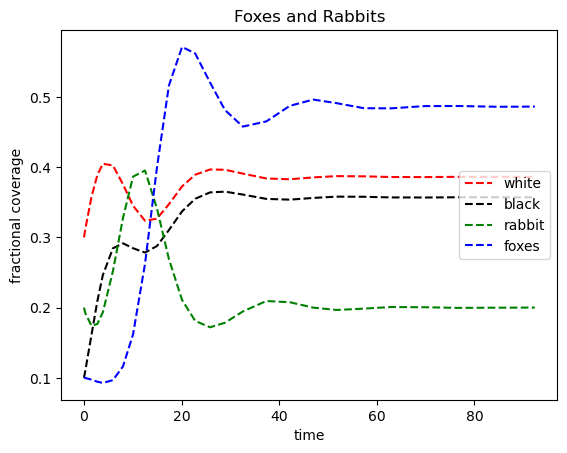

In [15]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes and Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

## Tests

In [110]:
theSolver = IntegFoxRabbit('foxrabbit_0.yaml')
initdict = {
    'rabbitconc':0.0,
    'foxconc':0.0,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

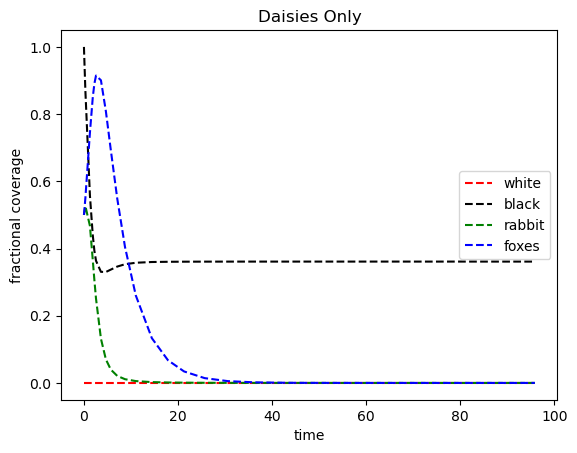

In [126]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Daisies Only')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

Setting initial foxes and rabbits to zero results in the same curve obtained for daisies only.

In [117]:
theSolver = IntegFoxRabbit('foxrabbit_0.yaml')
initdict = {
    'rabbitconc':0.0,
    'foxconc':0.5,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

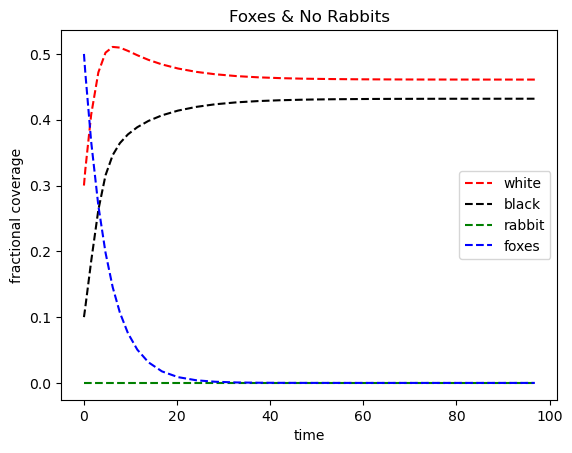

In [118]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes & No Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

The population of foxes collapses without any rabbits to support it.

In [123]:
theSolver = IntegFoxRabbit('foxrabbit_0.yaml')
initdict = {
    'rabbitconc':0.5,
    'foxconc':0.5,
    'whiteconc':0,
    'blackconc':1.0,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

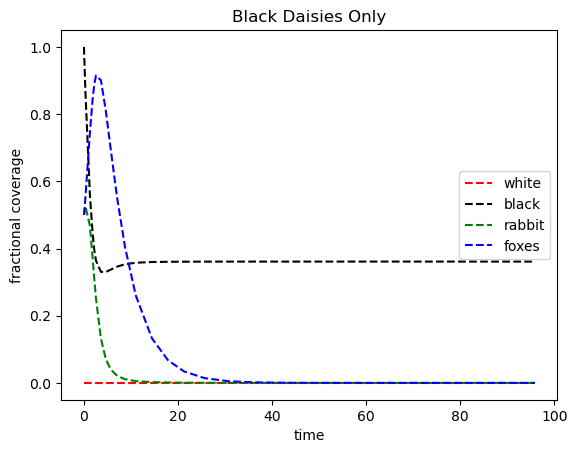

In [125]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Black Daisies Only')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

The equilibrium population of black daisies falls below the threshold needed to sustain a nonzero rabbit population. This also causes the fox population to fall to zero.

# Finding Predator-Prey Oscillations

The system of foxes, rabbits and daisies modeled thus far is effectively a Lotka-Volterra model coupled to the daisyworld equations through the birth rate of rabbits (and the rate at which rabbits eat daisies). Assuming that the population of daisies is approximately constant and at equilibrium, we can compare the fox and rabbit equations to the standard form of the Lotka-Volterra equations, which are:

$$
\frac{dx}{dt} = \alpha x - \beta xy
$$
$$
\frac{dy}{dt} = \delta xy - \gamma y
$$

Meanwhile the fox and rabbit equations are:

$$
\frac{d P_r}{dt} = [\beta_r (A_w + A_b) - \chi_{r0}] P_r - [\epsilon_f] P_r P_f
$$
$$
\frac{d P_f}{dt} = [\beta_f] P_r P_f - [\chi_f] P_f
$$

Letting $x = P_r$, $y = Pf$, we have $\alpha = \beta_r (A_w + A_b) - \chi_{r0}$, $\beta = \epsilon_f$, $\gamma = \chi_f$, and $\delta = \beta_f$.

The stability of fixed points are well-known for the Lotka-Volterra equations. The oscillating fixed point for the Lotka-Volterra equations are given by $(x, y) = (\frac{\gamma}{\delta}, \frac{\alpha}{\beta})$. Correspondingly, we can estimate the oscillating fixed point for to be at 

$$
(P_r, P_f) = \left(\frac{\chi_f}{\beta_f}, \frac{\beta_r (A_w + A_b) - \chi_{r0}}{\epsilon_f}\right)
$$

Thus if the daisy population remains close to equilibrium and does not fluctuate rapidly, the populations of rabbits and foxes are expect to oscillate about the fixed point.

## Estimating the fixed point

In [51]:
# Function that calculates the fixed point given an estimate for the total fraction of daisies
def fixed_point(init_yaml, A_total):
    with open(init_yaml, 'rb') as f:
            config = yaml.safe_load(f)
    uservars = namedtuple('uservars',config['uservars'].keys())
    u = uservars(**config['uservars'])
    
    chi_f = u.chifox
    beta_f = u.betafox
    beta_r = u.betarabbit
    chi_r0 = u.chi0rabbit
    epsilon_f = u.epsfox
    Pr = chi_f/beta_f
    Pf = (beta_r*A_total - chi_r0)/epsilon_f
    return Pr, Pf

In [42]:
print(fixed_point('foxrabbit_0.yaml', 0.75))

(0.2, 0.5)


Using the previous plot, the total equilibrium fraction of daisies is roughly 0.75. This yields an estimate of the fixed point at $(0.2, 0.5)$. Therefore in order to observe oscillations, the initial rabbit and fox concentrations have to be 'displaced' a sufficient amplitude away from the fixed points.

In [49]:
theSolver = IntegFoxRabbit('foxrabbit_0.yaml')
initdict = {
    'rabbitconc':0.5,
    'foxconc':0.9,
    'whiteconc':0.325,
    'blackconc':0.325,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

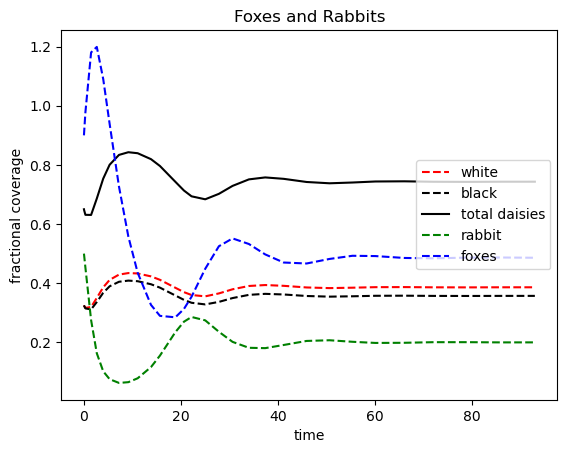

In [50]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line5, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line5.set(linestyle='-', color='k', label='total daisies')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes and Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

As expected, the population of rabbits and foxes seem to oscillate about $P_f = 0.5$ and $P_r = 0.2$. However, the oscillations damp out extremely quickly, and the system eventually reaches equilibrium. The number of oscillations before decaying can likely be increased by scaling the birth and death rates of rabbits and foxes, which increases the 'characteristic frequency' of the system.

In [67]:
theSolver = IntegFoxRabbit('foxrabbit_1.yaml') # betarabbit, chi0rabbit, epsfox, betafox, chifox are all uniformly scaled by 4X
initdict = {
    'rabbitconc':0.5,
    'foxconc':0.9,
    'whiteconc':0.325,
    'blackconc':0.325,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

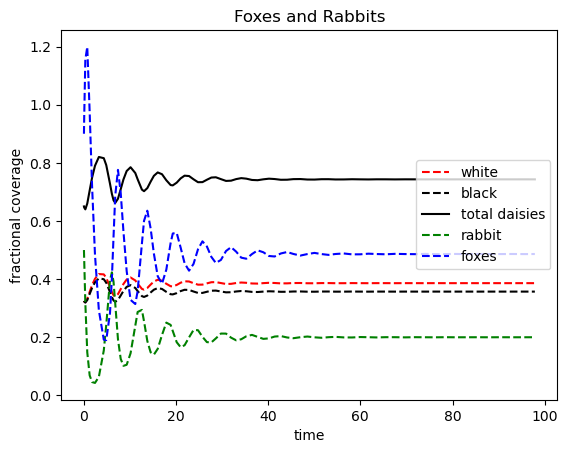

In [68]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line5, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line5.set(linestyle='-', color='k', label='total daisies')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes and Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

Here we see that the frequency of predator-prey oscillations is a lot higher. However the oscillations are still being damped at roughly the same rate as before. This seems to suggest that the source of damping arises outside of the fox and rabbit system. The likely culprit are the daisy equations.

In the standard Lotka-Volterra model, the birth rate of prey is constant, and in the absence of predators, the population of prey will increase exponentially. However, in our Daisyworld + rabbit model, the birth rate of rabbits depends on the population of daisies, and thus the system tends towards an equilibrium state where the overall growth rate of daisies is zero. Thus it stands to reason that in the full fox-rabbit-daisies model, the growth rate of daisies tends towards zero due to stabilizing feedback from the daisy system.

## Decoupling

We can test the hypothesis by decoupling the Daisyworld system from the fox-rabbit system. This can be done by setting `epsrabbit: 0`, which means that the population of rabbits will not affect the population of daisies, thus ensuring that the birth rate of rabbits is constant.

In [71]:
theSolver = IntegFoxRabbit('foxrabbit_test.yaml')
initdict = {
    'rabbitconc':0.5,
    'foxconc':0.9,
    'whiteconc':0.325,
    'blackconc':0.325,
}
theSolver.set_initvars(**initdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

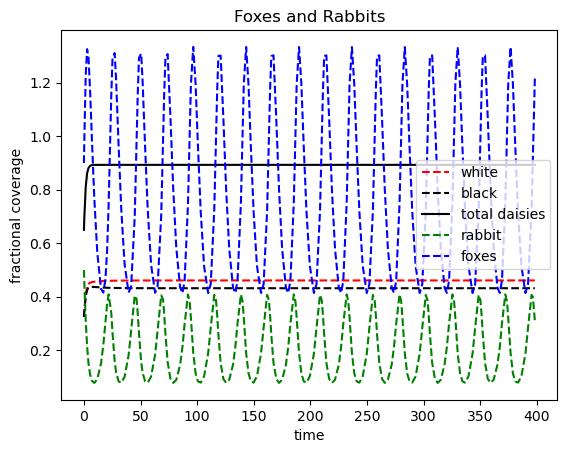

In [72]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line5, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line5.set(linestyle='-', color='k', label='total daisies')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes and Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

As expected, we see non-decaying predator prey oscillations without any damping effect. It also stands to reason that setting a small but nonzero `epsrabbit` will result in very slowly-decaying oscillations.

In [73]:
theSolver = IntegFoxRabbit('foxrabbit_test.yaml')
initdict = {
    'rabbitconc':0.2,
    'foxconc':0.4,
    'whiteconc':0.5,
    'blackconc':0.5,
}
userdict = {
    'epsrabbit':0.01
}
theSolver.set_initvars(**initdict)
theSolver.set_uservars(**userdict)
timevals, yvals, errorlist = theSolver.timeloop5Err()
populations = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

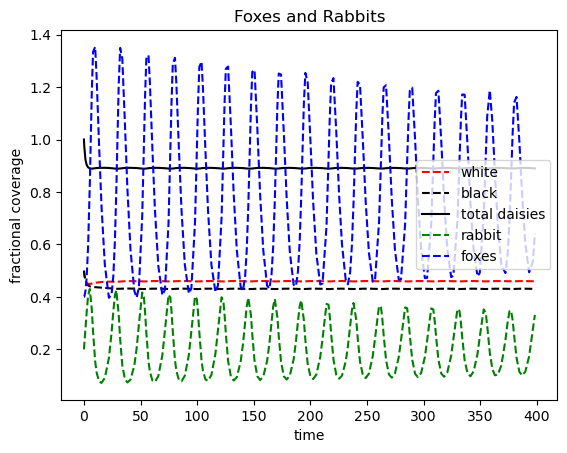

In [74]:
thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, populations['white'])
line2, = theAx.plot(timevals, populations['black'])
line5, = theAx.plot(timevals, populations['white'] + populations['black'])
line3, = theAx.plot(timevals, populations['rabbits'])
line4, = theAx.plot(timevals, populations['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line5.set(linestyle='-', color='k', label='total daisies')
line3.set(linestyle='--', color='g', label='rabbit')
line4.set(linestyle='--', color='b', label='foxes')
theAx.set_title('Foxes and Rabbits')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

Such a solution however seems to imply that rabbits are magically spawning in the mere presence of daisies without really consuming them. This seems unphysical. This might mean that in physically realistic ecosystems where multiple producers and consumers are coupled together, we should see predator-prey oscillations quickly damping out. However, persistent predator-prey oscillations are observed in nature.

This can possibly be accounted for by recalling that the quantities involved in this simulation are dimensionless quantities with arbitrary scaling. An extremely small eating rate parameter `epsrabbit` can be understood as being rescaled to reflect that the population of daisies is far larger than that of rabbits, thus within the typical scale of rabbit populations, food is abundant and there is very little competition between rabbits. The presence of foxes keeps the population to a low level such that the population fraction of daisies are not much affected by variations in the population of daisies. Without the presence of a predator like fox, the rabbit population will undergo exponential growth until it reaches a scale where competition for food becomes an important mechanism for limiting the population.